# 📊 Proyecto Guiado - Análisis de Ventas de Videojuegos
## Parte 3: Limpieza y Preparación de Datos

---

### 🎯 Objetivos de este notebook:
1. Limpiar valores nulos y decidir estrategias de imputación
2. Tratar outliers y valores anómalos
3. Crear nuevas variables (feature engineering)
4. Transformar y categorizar datos
5. Exportar dataset limpio para la aplicación

---

### 📚 ¿Por qué limpiar los datos?

Los datos del mundo real son **sucios**:
- Valores faltantes
- Errores de entrada
- Inconsistencias
- Outliers que distorsionan análisis

**Un buen análisis requiere datos limpios.**

---
## 1. Cargar librerías y datos

In [2]:
# Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Configuraciones
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')

# Cargar dataset original
df = pd.read_csv('../data/vgsales.csv')

print("✅ Dataset cargado")
print(f"📦 Dimensiones iniciales: {df.shape}")
print(f"❓ Valores nulos totales: {df.isnull().sum().sum()}")

FileNotFoundError: [Errno 2] No such file or directory: '../data/vgsales.csv'

---
## 2. Tratamiento de Valores Nulos

### 2.1 Identificar valores nulos

In [3]:
# Análisis detallado de nulos
print("❓ ANÁLISIS DE VALORES NULOS")
print("=" * 80)

nulos = df.isnull().sum()
nulos_pct = (nulos / len(df) * 100).round(2)

nulos_df = pd.DataFrame({
    'Columna': nulos.index,
    'Nulos': nulos.values,
    'Porcentaje': nulos_pct.values
}).query('Nulos > 0').sort_values('Nulos', ascending=False)

print(nulos_df.to_string(index=False))

# Visualizar filas con nulos
print("\n📋 Ejemplos de registros con valores nulos:")
print(df[df.isnull().any(axis=1)].head(10))

❓ ANÁLISIS DE VALORES NULOS


NameError: name 'df' is not defined

### 2.2 Estrategias para manejar nulos

**Opciones:**
1. **Eliminar** filas/columnas (si son pocos)
2. **Imputar** con media/mediana/moda
3. **Rellenar** con valor específico (ej: 'Unknown')
4. **Predecir** usando otros datos

**Nuestra estrategia:**
- **Year**: Intentar inferir del contexto, si no es posible → eliminar
- **Publisher**: Rellenar con 'Unknown'

In [ ]:
# Estrategia de limpieza de valores nulos
# Decisiones basadas en el contexto y el impacto en el análisis

# Crear una copia del DataFrame para no modificar el original
# Esto es una buena práctica: siempre mantener los datos originales intactos
df_clean = df.copy()

# 1. Tratar Publisher nulos
# DECISIÓN: Rellenar con 'Unknown'
# RAZÓN: Solo ~1.8% de nulos, y eliminar filas perdería información valiosa de ventas
#        'Unknown' nos permite mantener estos registros en análisis generales
#        aunque no podamos analizarlos por publisher
print("🔧 Tratando valores nulos en Publisher...")
nulos_publisher_antes = df['Publisher'].isnull().sum()
df_clean['Publisher'] = df_clean['Publisher'].fillna('Unknown')  # .fillna() rellena valores nulos
print(f"   ✅ Rellenados {nulos_publisher_antes} valores con 'Unknown'")

# 2. Tratar Year nulos
# DECISIÓN: Eliminar registros sin año
# RAZÓN: El año es crucial para análisis temporales (evolución, décadas, etc.)
#        Son solo ~271 filas (~1.6%), el impacto es mínimo
#        No podemos "adivinar" el año con precisión razonable
print("\n🔧 Tratando valores nulos en Year...")
print(f"   Registros con Year nulo: {df_clean['Year'].isnull().sum()}")

filas_antes = len(df_clean)
df_clean = df_clean.dropna(subset=['Year'])  # dropna() elimina filas con nulos en columnas específicas
filas_despues = len(df_clean)
print(f"   ✅ Eliminadas {filas_antes - filas_despues} filas sin año")

# Convertir Year a entero (era float por los NaN)
# Los años deben ser enteros (2008, no 2008.0)
df_clean['Year'] = df_clean['Year'].astype(int)

# Verificación final: Asegurar que no quedaron nulos
print("\n✅ VERIFICACIÓN FINAL DE NULOS")
print("=" * 80)
nulos_restantes = df_clean.isnull().sum().sum()
print(f"Total de valores nulos restantes: {nulos_restantes}")
print(f"Dimensiones finales: {df_clean.shape}")

# Si nulos_restantes == 0, ¡éxito! Dataset completamente limpio de nulos

🔧 Tratando valores nulos en Publisher...
   ✅ Rellenados 58 valores con 'Unknown'

🔧 Tratando valores nulos en Year...
   Registros con Year nulo: 271
   ✅ Eliminadas 271 filas sin año

✅ VERIFICACIÓN FINAL DE NULOS
Total de valores nulos restantes: 0
Dimensiones finales: (16327, 11)


---
## 3. Análisis y Tratamiento de Outliers

### 3.1 ¿Qué son los outliers?

**Outliers** son valores atípicos que se desvían significativamente del resto.

**En nuestro caso:**
- Juegos con ventas extraordinariamente altas (ej: Wii Sports)
- Estos NO son errores, son éxitos reales
- **Decisión**: Los mantenemos porque son datos válidos y valiosos

In [1]:
# Identificar outliers usando el método IQR (Interquartile Range)
# IQR es uno de los métodos estadísticos más robustos para detectar valores atípicos

def detectar_outliers_iqr(columna):
    """
    Detecta outliers usando el método IQR (Rango Intercuartílico):
    
    Conceptos clave:
    - Q1 (Primer Cuartil): 25% de los datos están por debajo
    - Q3 (Tercer Cuartil): 75% de los datos están por debajo
    - IQR (Rango Intercuartílico): Q3 - Q1 
      * Representa el 50% central de los datos (el rango "normal")
    
    Regla de detección (convención estadística):
    - Límite inferior: Q1 - 1.5 * IQR
      * Valores por debajo son outliers bajos (anormalmente pequeños)
    - Límite superior: Q3 + 1.5 * IQR  
      * Valores por encima son outliers altos (anormalmente grandes)
    
    El factor 1.5 es estándar en estadística (criterio de Tukey)
    Captura aproximadamente el 99.3% de datos en distribución normal
    
    Returns:
        outliers (bool array): True donde hay outliers
        limite_inferior (float): Umbral inferior
        limite_superior (float): Umbral superior
    """
    Q1 = columna.quantile(0.25)  # Percentil 25
    Q3 = columna.quantile(0.75)  # Percentil 75
    IQR = Q3 - Q1
    
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    
    # Crear máscara booleana: True si es outlier (menor que lim_inf O mayor que lim_sup)
    outliers = (columna < limite_inferior) | (columna > limite_superior)
    return outliers, limite_inferior, limite_superior

# Analizar outliers en Global_Sales
outliers, lim_inf, lim_sup = detectar_outliers_iqr(df_clean['Global_Sales'])

print("📊 ANÁLISIS DE OUTLIERS EN VENTAS GLOBALES")
print("=" * 80)
print(f"Límite inferior: {lim_inf:.2f} (valores por debajo son outliers)")
print(f"Límite superior: {lim_sup:.2f} (valores por encima son outliers)")
print(f"Cantidad de outliers: {outliers.sum()} ({outliers.sum()/len(df_clean)*100:.1f}%)")

# Mostrar los outliers superiores (juegos más vendidos)
print("\n🏆 Top 15 'Outliers' (Juegos más exitosos):")
print(df_clean[outliers].nlargest(15, 'Global_Sales')[['Name', 'Platform', 'Year', 'Genre', 'Global_Sales']])

print("\n💡 Decisión: Mantenemos estos outliers porque representan éxitos reales de la industria.")
print("   En este caso, los 'outliers' son juegos genuinamente excepcionales (Wii Sports, GTA V, etc.)")
print("   NO son errores de medición ni datos incorrectos.")
print("   Eliminarlos significaría perder información valiosa sobre los mayores éxitos de la industria.")

NameError: name 'df_clean' is not defined

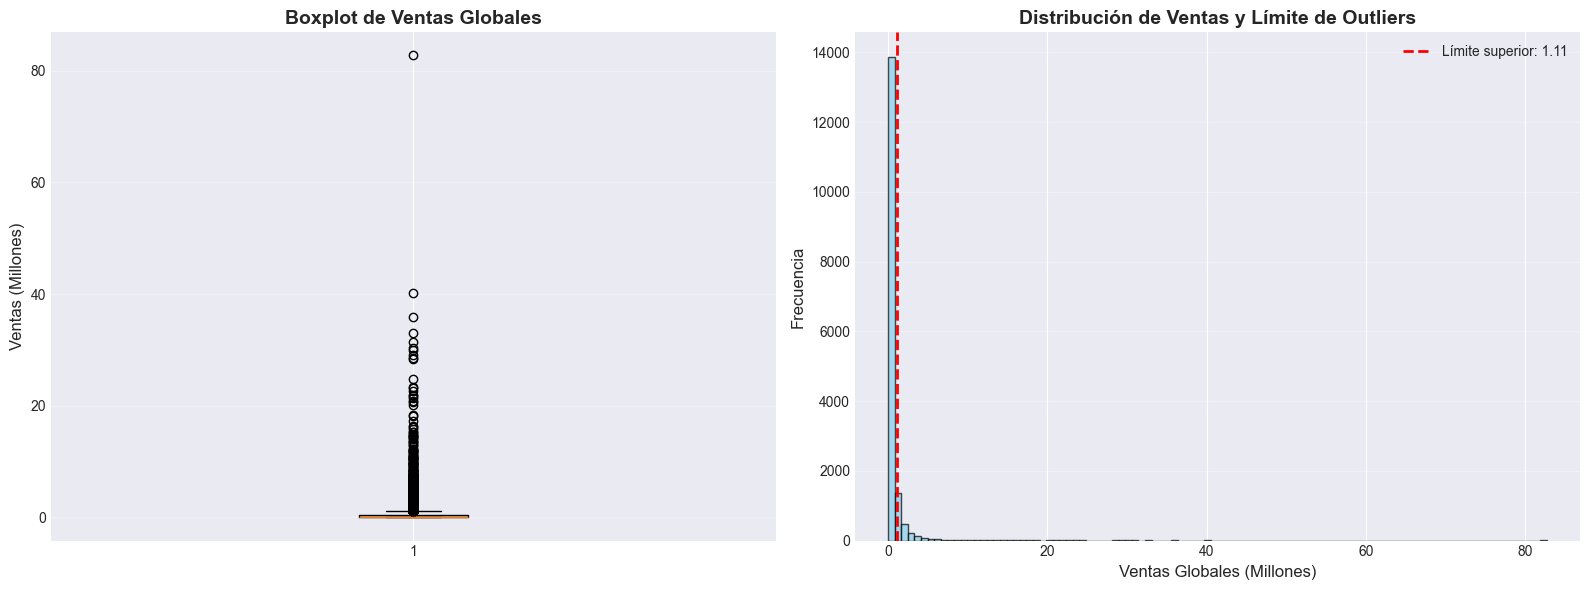

In [5]:
# Visualización de outliers
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Boxplot
axes[0].boxplot(df_clean['Global_Sales'], vert=True)
axes[0].set_title('Boxplot de Ventas Globales', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Ventas (Millones)', fontsize=12)
axes[0].grid(axis='y', alpha=0.3)

# Histograma con líneas de límites
axes[1].hist(df_clean['Global_Sales'], bins=100, color='skyblue', edgecolor='black', alpha=0.7)
axes[1].axvline(lim_sup, color='red', linestyle='--', linewidth=2, label=f'Límite superior: {lim_sup:.2f}')
axes[1].set_title('Distribución de Ventas y Límite de Outliers', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Ventas Globales (Millones)', fontsize=12)
axes[1].set_ylabel('Frecuencia', fontsize=12)
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

---
## 4. Feature Engineering - Crear Nuevas Variables

Vamos a crear variables nuevas que nos ayuden en el análisis.

### 4.1 Década de lanzamiento

In [ ]:
# Crear columna de década para análisis temporal agregado
# Feature Engineering: Crear nuevas variables a partir de las existentes

def asignar_decada(year):
    """
    Asigna la década correspondiente a un año.
    
    Lógica:
    - Dividir el año entre 10 (división entera) → elimina el último dígito
    - Multiplicar por 10 → obtiene el inicio de la década
    
    Ejemplos:
    - 1985 → 1985 // 10 = 198 → 198 * 10 = 1980 → "1980s"
    - 2005 → 2005 // 10 = 200 → 200 * 10 = 2000 → "2000s"
    - 2019 → 2019 // 10 = 201 → 201 * 10 = 2010 → "2010s"
    
    ¿Por qué crear esta columna?
    - Facilita análisis de tendencias a largo plazo
    - Agrupa años individuales en períodos significativos
    - Útil para visualizaciones más limpias (menos categorías que años individuales)
    - Permite comparar eras de la industria (80s vs 90s vs 2000s)
    
    Returns:
        str: Década en formato "1980s", "1990s", etc.
    """
    decada = (year // 10) * 10  # Operador // es división entera (descarta decimales)
    return f"{decada}s"  # f-string para formatear: valor + "s"

# Aplicar la función a cada fila del DataFrame
# .apply() ejecuta la función para cada valor de la columna Year
df_clean['Decade'] = df_clean['Year'].apply(asignar_decada)

print("✅ Columna 'Decade' creada exitosamente")
print("\nDistribución de juegos por década:")
decade_counts = df_clean['Decade'].value_counts().sort_index()
print(decade_counts)

# Insight: Veremos que los 2000s y 2010s dominan el dataset
# Esto refleja el boom de la industria moderna de videojuegos

✅ Columna 'Decade' creada

Distribución de juegos por década:
Decade
1980s     205
1990s    1769
2000s    9208
2010s    5144
2020s       1
Name: count, dtype: int64


### 4.2 Categoría de ventas (bajo, medio, alto, mega-éxito)

✅ Columna 'Sales_Category' creada

Distribución de categorías de ventas:
Sales_Category
Bajo          12362
Medio          3124
Alto            779
Mega-éxito       62
Name: count, dtype: int64


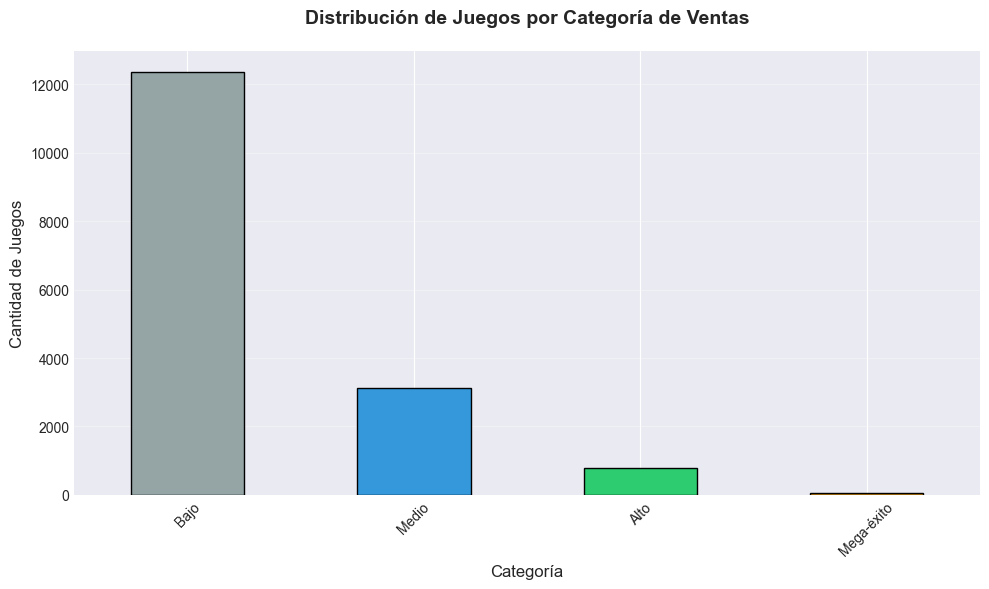

In [ ]:
# Categorizar ventas en niveles de éxito
# Esto convierte una variable continua (ventas) en categórica (niveles)

def categorizar_ventas(ventas):
    """
    Categoriza las ventas en niveles de éxito comercial.
    
    Categorías basadas en el análisis de la industria:
    - Bajo (< 0.5M): Juegos con ventas limitadas, nichos pequeños
      * Representa la mayoría de juegos en el mercado
      * Pueden ser rentables si el presupuesto fue bajo
    
    - Medio (0.5M - 2M): Éxitos moderados
      * Juegos que recuperaron inversión y generaron beneficios
      * Base de fans establecida pero no mainstream
    
    - Alto (2M - 10M): Gran éxito comercial
      * Franquicias reconocidas, juegos AAA exitosos
      * Generan beneficios significativos
    
    - Mega-éxito (> 10M): Fenómenos culturales
      * Wii Sports, GTA, Call of Duty, Pokemon
      * Definen generaciones y plataformas
      * Menos del 2% de todos los juegos
    
    Estos umbrales son estándar en la industria para definir éxito comercial.
    
    Args:
        ventas (float): Ventas en millones
        
    Returns:
        str: Categoría de ventas
    """
    if ventas < 0.5:
        return 'Bajo'
    elif ventas < 2:
        return 'Medio'
    elif ventas < 10:
        return 'Alto'
    else:
        return 'Mega-éxito'

# Aplicar categorización a cada juego
df_clean['Sales_Category'] = df_clean['Global_Sales'].apply(categorizar_ventas)

print("✅ Columna 'Sales_Category' creada")
print("\nDistribución de categorías de ventas:")
category_counts = df_clean['Sales_Category'].value_counts()
print(category_counts)
print(f"\nPorcentajes:")
print((category_counts / len(df_clean) * 100).round(2))

# Visualización con colores significativos
# Gris para Bajo, Azul para Medio, Verde para Alto, Dorado para Mega-éxito
plt.figure(figsize=(10, 6))
df_clean['Sales_Category'].value_counts().plot(
    kind='bar', 
    color=['#95a5a6', '#3498db', '#2ecc71', '#f39c12'],  # Colores que reflejan el nivel
    edgecolor='black'
)
plt.title('Distribución de Juegos por Categoría de Ventas', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Categoría', fontsize=12)
plt.ylabel('Cantidad de Juegos', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Insight esperado: La pirámide del éxito - muchos juegos en Bajo, muy pocos en Mega-éxito

### 4.3 Región dominante (dónde vende más)

✅ Columna 'Dominant_Region' creada

Distribución de región dominante:
Dominant_Region
NA       9925
JP       3986
EU       2340
Other      76
Name: count, dtype: int64


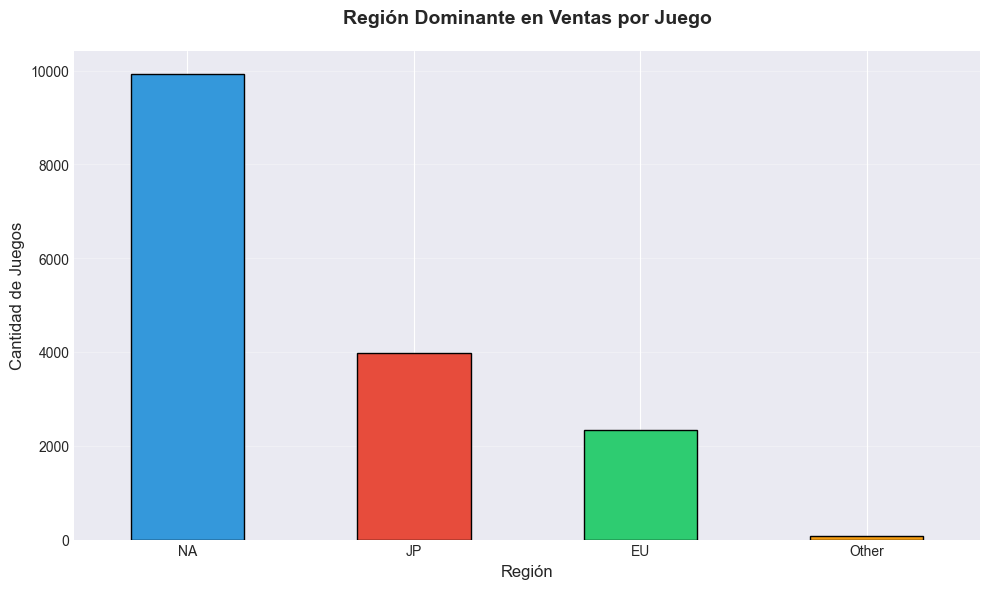

In [8]:
# Identificar región con mayores ventas para cada juego
def region_dominante(row):
    """
    Determina en qué región el juego tuvo más ventas.
    """
    ventas_regiones = {
        'NA': row['NA_Sales'],
        'EU': row['EU_Sales'],
        'JP': row['JP_Sales'],
        'Other': row['Other_Sales']
    }
    return max(ventas_regiones, key=ventas_regiones.get)

df_clean['Dominant_Region'] = df_clean.apply(region_dominante, axis=1)

print("✅ Columna 'Dominant_Region' creada")
print("\nDistribución de región dominante:")
print(df_clean['Dominant_Region'].value_counts())

# Visualización
plt.figure(figsize=(10, 6))
colores = {'NA': '#3498db', 'EU': '#2ecc71', 'JP': '#e74c3c', 'Other': '#f39c12'}
region_counts = df_clean['Dominant_Region'].value_counts()
region_counts.plot(kind='bar', color=[colores[x] for x in region_counts.index], edgecolor='black')
plt.title('Región Dominante en Ventas por Juego', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Región', fontsize=12)
plt.ylabel('Cantidad de Juegos', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

### 4.4 Porcentaje de ventas por región

In [9]:
# Calcular porcentajes de ventas por región
df_clean['NA_Percentage'] = (df_clean['NA_Sales'] / df_clean['Global_Sales'] * 100).round(2)
df_clean['EU_Percentage'] = (df_clean['EU_Sales'] / df_clean['Global_Sales'] * 100).round(2)
df_clean['JP_Percentage'] = (df_clean['JP_Sales'] / df_clean['Global_Sales'] * 100).round(2)
df_clean['Other_Percentage'] = (df_clean['Other_Sales'] / df_clean['Global_Sales'] * 100).round(2)

print("✅ Columnas de porcentajes creadas")
print("\nEjemplos de porcentajes de ventas:")
print(df_clean[['Name', 'NA_Percentage', 'EU_Percentage', 'JP_Percentage', 'Other_Percentage']].head(10))

✅ Columnas de porcentajes creadas

Ejemplos de porcentajes de ventas:
                        Name  NA_Percentage  EU_Percentage  JP_Percentage  \
0                 Wii Sports          50.15          35.07           4.56   
1          Super Mario Bros.          72.27           8.90          16.92   
2             Mario Kart Wii          44.25          35.96          10.58   
3          Wii Sports Resort          47.73          33.36           9.94   
4   Pokemon Red/Pokemon Blue          35.93          28.34          32.58   
5                     Tetris          76.67           7.47          13.95   
6      New Super Mario Bros.          37.92          30.76          21.66   
7                   Wii Play          48.35          31.70          10.10   
8  New Super Mario Bros. Wii          50.98          24.67          16.42   
9                  Duck Hunt          95.13           2.23           0.99   

   Other_Percentage  
0             10.22  
1              1.91  
2              9

### 4.5 Tipo de plataforma (Consola, Portátil, PC)

✅ Columna 'Platform_Type' creada

Distribución por tipo de plataforma:
Platform_Type
Consola     10234
Portátil     5150
PC            943
Name: count, dtype: int64


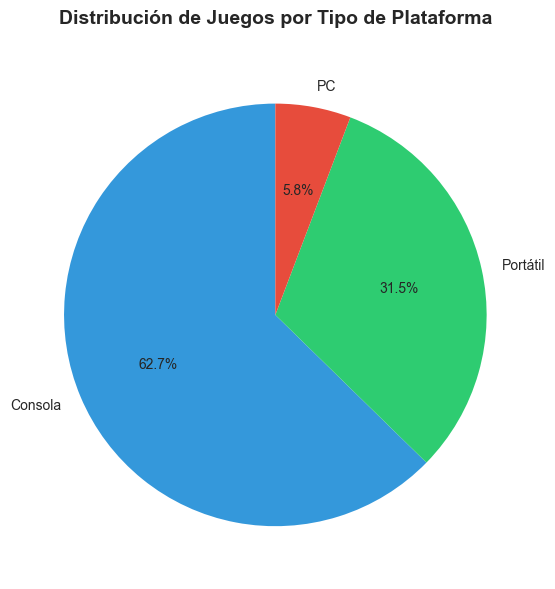

In [10]:
# Clasificar plataformas por tipo
def tipo_plataforma(platform):
    """
    Clasifica las plataformas en categorías:
    - Consola de sobremesa
    - Portátil
    - PC
    """
    portatiles = ['GB', 'GBA', 'DS', '3DS', 'PSP', 'PSV']
    pc = ['PC']
    
    if platform in portatiles:
        return 'Portátil'
    elif platform in pc:
        return 'PC'
    else:
        return 'Consola'

df_clean['Platform_Type'] = df_clean['Platform'].apply(tipo_plataforma)

print("✅ Columna 'Platform_Type' creada")
print("\nDistribución por tipo de plataforma:")
print(df_clean['Platform_Type'].value_counts())

# Visualización
plt.figure(figsize=(10, 6))
df_clean['Platform_Type'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, 
                                                colors=['#3498db', '#2ecc71', '#e74c3c'])
plt.title('Distribución de Juegos por Tipo de Plataforma', fontsize=14, fontweight='bold', pad=20)
plt.ylabel('')
plt.tight_layout()
plt.show()

---
## 5. Verificación Final del Dataset Limpio

In [11]:
# Resumen final del dataset limpio
print("📊 RESUMEN FINAL DEL DATASET LIMPIO")
print("=" * 80)
print(f"\n📦 Dimensiones: {df_clean.shape}")
print(f"❓ Valores nulos totales: {df_clean.isnull().sum().sum()}")
print(f"\n📋 Columnas totales: {len(df_clean.columns)}")
print("\nColumnas originales (11):")
print(df.columns.tolist())
print("\nColumnas nuevas creadas (6):")
nuevas_columnas = set(df_clean.columns) - set(df.columns)
print(list(nuevas_columnas))

📊 RESUMEN FINAL DEL DATASET LIMPIO

📦 Dimensiones: (16327, 19)
❓ Valores nulos totales: 0

📋 Columnas totales: 19

Columnas originales (11):
['Rank', 'Name', 'Platform', 'Year', 'Genre', 'Publisher', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales']

Columnas nuevas creadas (6):
['NA_Percentage', 'EU_Percentage', 'Sales_Category', 'JP_Percentage', 'Platform_Type', 'Decade', 'Dominant_Region', 'Other_Percentage']


In [12]:
# Vista general del dataset limpio
print("🔍 VISTA GENERAL DEL DATASET LIMPIO")
print("=" * 80)
df_clean.info()

print("\n📊 Primeras filas del dataset limpio:")
df_clean.head(10)

🔍 VISTA GENERAL DEL DATASET LIMPIO
<class 'pandas.core.frame.DataFrame'>
Index: 16327 entries, 0 to 16597
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Rank              16327 non-null  int64  
 1   Name              16327 non-null  object 
 2   Platform          16327 non-null  object 
 3   Year              16327 non-null  int64  
 4   Genre             16327 non-null  object 
 5   Publisher         16327 non-null  object 
 6   NA_Sales          16327 non-null  float64
 7   EU_Sales          16327 non-null  float64
 8   JP_Sales          16327 non-null  float64
 9   Other_Sales       16327 non-null  float64
 10  Global_Sales      16327 non-null  float64
 11  Decade            16327 non-null  object 
 12  Sales_Category    16327 non-null  object 
 13  Dominant_Region   16327 non-null  object 
 14  NA_Percentage     16327 non-null  float64
 15  EU_Percentage     16327 non-null  float64
 16  JP_Percent

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Decade,Sales_Category,Dominant_Region,NA_Percentage,EU_Percentage,JP_Percentage,Other_Percentage,Platform_Type
0,1,Wii Sports,Wii,2006,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74,2000s,Mega-éxito,NA,50.15,35.07,4.56,10.22,Consola
1,2,Super Mario Bros.,NES,1985,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,1980s,Mega-éxito,NA,72.27,8.90,16.92,1.91,Consola
2,3,Mario Kart Wii,Wii,2008,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82,2000s,Mega-éxito,NA,44.25,35.96,10.58,9.24,Consola
3,4,Wii Sports Resort,Wii,2009,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00,2000s,Mega-éxito,NA,47.73,33.36,9.94,8.97,Consola
4,5,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,1990s,Mega-éxito,NA,35.93,28.34,32.58,3.19,Portátil
5,6,Tetris,GB,1989,Puzzle,Nintendo,23.20,2.26,4.22,0.58,30.26,1980s,Mega-éxito,NA,76.67,7.47,13.95,1.92,Portátil
6,7,New Super Mario Bros.,DS,2006,Platform,Nintendo,11.38,9.23,6.50,2.90,30.01,2000s,Mega-éxito,NA,37.92,30.76,21.66,9.66,Portátil
7,8,Wii Play,Wii,2006,Misc,Nintendo,14.03,9.20,2.93,2.85,29.02,2000s,Mega-éxito,NA,48.35,31.70,10.10,9.82,Consola
8,9,New Super Mario Bros. Wii,Wii,2009,Platform,Nintendo,14.59,7.06,4.70,2.26,28.62,2000s,Mega-éxito,NA,50.98,24.67,16.42,7.90,Consola
9,10,Duck Hunt,NES,1984,Shooter,Nintendo,26.93,0.63,0.28,0.47,28.31,1980s,Mega-éxito,NA,95.13,2.23,0.99,1.66,Consola


---
## 6. Exportar Dataset Limpio

Guardamos el dataset procesado para usarlo en:
1. Análisis avanzados
2. Aplicación web con Streamlit
3. Futuros proyectos

In [13]:
# Exportar dataset limpio
output_path = '../data/vgsales_clean.csv'
df_clean.to_csv(output_path, index=False)

print("✅ DATASET LIMPIO EXPORTADO EXITOSAMENTE")
print("=" * 80)
print(f"📁 Ruta: {output_path}")
print(f"📦 Registros: {len(df_clean):,}")
print(f"📋 Columnas: {len(df_clean.columns)}")
print(f"💾 Tamaño: {df_clean.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Verificar que se guardó correctamente
import os
if os.path.exists(output_path):
    file_size = os.path.getsize(output_path) / 1024**2
    print(f"✅ Archivo guardado correctamente ({file_size:.2f} MB)")
else:
    print("❌ Error al guardar el archivo")

✅ DATASET LIMPIO EXPORTADO EXITOSAMENTE
📁 Ruta: ../data/vgsales_clean.csv
📦 Registros: 16,327
📋 Columnas: 19
💾 Tamaño: 8.70 MB
✅ Archivo guardado correctamente (2.00 MB)


---
## ✅ Resumen de Transformaciones Realizadas

### 🧹 Limpieza:
1. ✅ **Valores nulos eliminados/imputados:**
   - Year: Eliminadas ~271 filas sin año
   - Publisher: Rellenados ~58 valores con 'Unknown'

2. ✅ **Outliers analizados:**
   - Identificados pero mantenidos (son datos válidos)

### 🔨 Feature Engineering (6 nuevas columnas):
1. ✅ **Decade**: Década de lanzamiento
2. ✅ **Sales_Category**: Categoría de ventas (Bajo/Medio/Alto/Mega-éxito)
3. ✅ **Dominant_Region**: Región con más ventas
4. ✅ **NA/EU/JP/Other_Percentage**: Porcentaje de ventas por región
5. ✅ **Platform_Type**: Tipo de plataforma (Consola/Portátil/PC)

### 📊 Dataset Final:
- **Filas**: 16,327 (eliminadas 271)
- **Columnas**: 17 (11 originales + 6 nuevas)
- **Valores nulos**: 0
- **Exportado**: ✅ data/vgsales_clean.csv

---

### 🎯 Próximos Pasos:

En el siguiente notebook (04_analisis_estadistico.ipynb) haremos:
- Análisis de correlaciones
- Estadísticas avanzadas por grupos
- Tendencias temporales
- Análisis comparativos entre regiones

---

### 💡 Ejercicios para practicar:

1. Crea una columna que identifique juegos "exclusivos de región" (>80% ventas en una región)
2. Categoriza los publishers en "grandes" (>50 juegos) vs "pequeños"
3. Crea una métrica de "éxito" combinando ventas y año
4. Experimenta con diferentes categorías de ventas